In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tifffile import imread

In [6]:
atals_ref_path = "/nfs/data5/chuyu/data/20220416_123633/T_AVG_jf5Tg.tif"
atlas_ref = imread(atals_ref_path)
atlas_ref = np.swapaxes(atlas_ref, 0, 2)
atlas_ref.shape

(597, 974, 359)

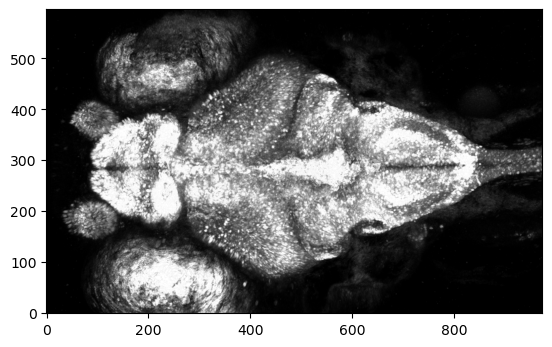

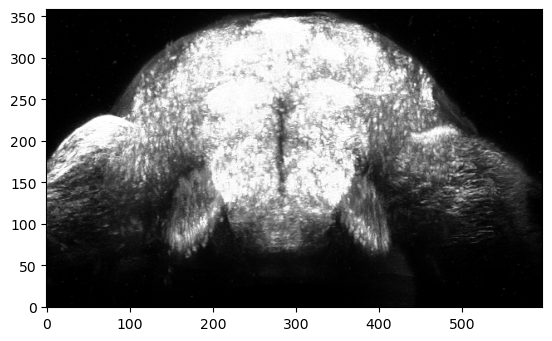

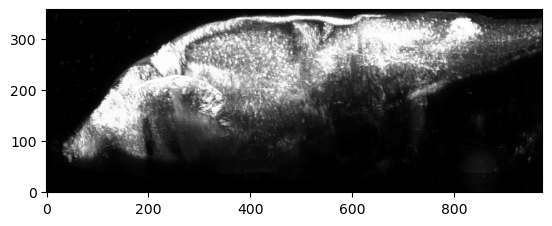

In [10]:
stack_img = atlas_ref
fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=2)
ax.imshow(fig_bg, cmap="gray",origin="lower")


fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=1)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")

fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=0)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")

In [116]:
datapath = "/nfs/data8/chuyu/data/connectome/Kunst_et_al.,_2019_155076"
filelist = [f for f in os.listdir(datapath) if f.endswith(".swc")]

In [117]:
filelist[0]

'T_150324_fixed_12_3_full_tracing.swc'

In [54]:
def load_swc(filepath):
    """Load SWC file and return as a NumPy array."""
    return np.loadtxt(filepath)


def readSWC(filename, as_list=False):
    '''Read an .swc file into a np.array or a list of lists.'''
    with open(filename, 'r') as f:
        trace = []
        for line in f:
            if line[0] != '#':
                strings = line.split()
                nums = [float(c) for c in strings]
                trace.append(nums)
    trace_array = np.array(trace)
    if as_list:
        return trace
    else:
        return trace_array

def thisNode(index, tree, as_list=True):
    '''Return the node at index from tree as list or np.array.'''
    if isinstance(tree, list):
        tree = np.array(tree)  
    current_node = tree[np.where(tree[:,0]==index)]
    current_node = current_node.reshape(current_node.shape[1])
    if as_list:
        return current_node.tolist()
    else:
        return current_node
    
def findEndpoints(tree, return_node=False):
    '''Return the indices (or nodes) of endpoints.'''
    if isinstance(tree, list):
        tree = np.array(tree)
    indices = tree[:,0]
    parents = tree[:,6]
    endpoints = list(set(indices) - set(parents))
    if return_node:
        endpoint_nodes = []
        for index in endpoints:
            node = thisNode(index, tree)
            endpoint_nodes.append(node)
        return np.array(endpoint_nodes)
    else:
        return np.array(endpoints)

def create_mask(volume_size, center, r):
    """Generate a 3D binary mask where all voxels within radius r from center are 1."""
    x, y, z = np.indices(volume_size)  # Create coordinate grid
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)  # Euclidean distance
    mask = dist <= r  # Set voxels inside radius to 1 (True), others to 0 (False)
    return mask

In [98]:
atlas_ref.shape

(597, 974, 359)

In [99]:
atlas_ref.shape[0] - target_center[0]

408

In [17]:
target_center = (189, 403, 125)
use_mirror_target = True

target_mask = create_mask(atlas_ref.shape, target_center, 50)
if use_mirror_target:
    target_mask_mirror = target_mask[::-1,:,:]
target_mask = target_mask + target_mask_mirror

In [106]:
target_mask.shape

(597, 974, 359)

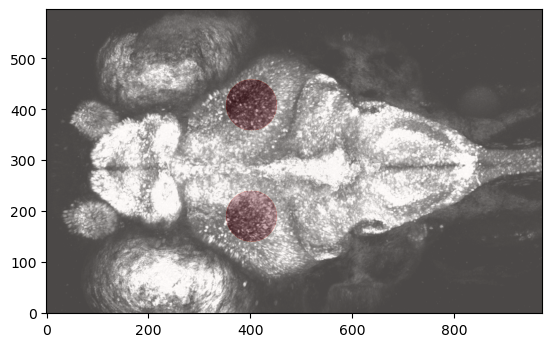

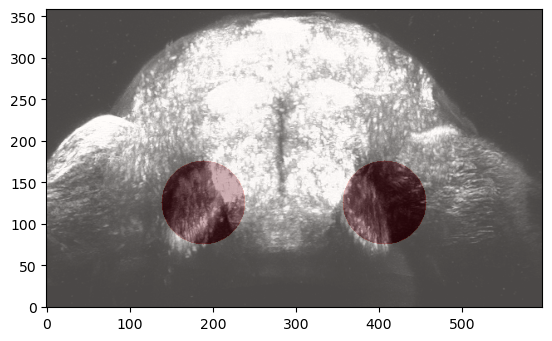

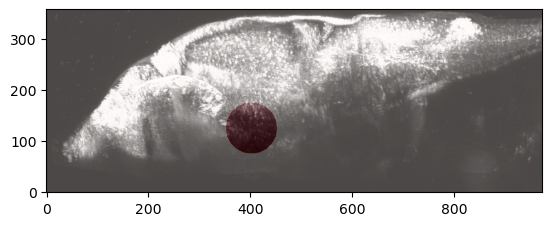

In [108]:
stack_img = atlas_ref
mask = target_mask
fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=2)
ax.imshow(fig_bg, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=2)
ax.imshow(mask_img, cmap="Reds",origin="lower", alpha = 0.3)

fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=1)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=1)
ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)


fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=0)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=0)
ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)

In [109]:
soma_xyz_all =np.zeros((len(filelist), 3))
for i in range(len(filelist)):
    swc_data = readSWC(os.path.join(datapath, filelist[i]))
    soma_xyz_all[i,:] = swc_data[0,[2,3,4]]

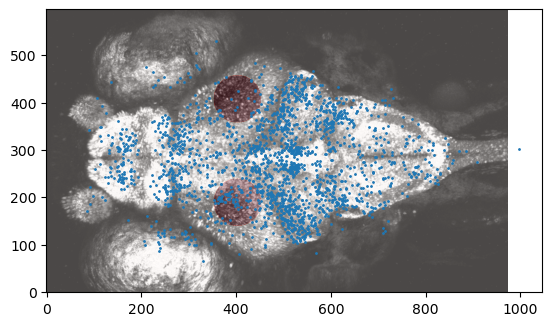

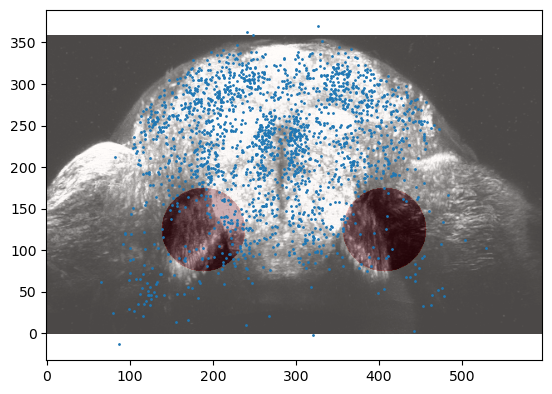

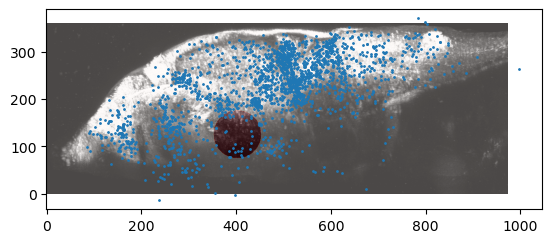

In [110]:
stack_img = atlas_ref
mask = target_mask
soma_locs = soma_xyz_all
fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=2)
ax.imshow(fig_bg, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=2)
ax.imshow(mask_img, cmap="Reds",origin="lower", alpha = 0.3)
ax.scatter(soma_locs[:,1], soma_locs[:,0], s= 1)

fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=1)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=1)
ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)
ax.scatter(soma_locs[:,0], soma_locs[:,2], s= 1)

fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=0)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=0)
ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)
ax.scatter(soma_locs[:,1], soma_locs[:,2], s= 1)

In [111]:
whether_in_region = np.zeros(soma_xyz_all.shape[0])
for i in range(len(whether_in_region)):
    x = np.round(soma_xyz_all[i,0]).astype(int)-1
    y = np.round(soma_xyz_all[i,1]).astype(int)-1
    z = np.round(soma_xyz_all[i,2]).astype(int)-1
    if (x<=target_mask.shape[0]) * (y<=target_mask.shape[1]) * (z<=target_mask.shape[2]) * (x>=0) * (y>=0) * (z>=0):
        whether_in_region[i] = target_mask[x, y, z] #check if it's in any brain region we define
whether_in_region = whether_in_region>0

In [112]:
np.sum(whether_in_region)

10

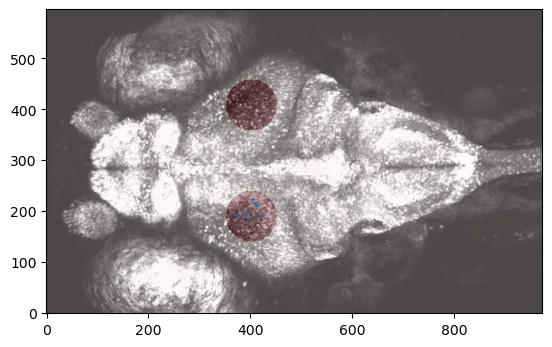

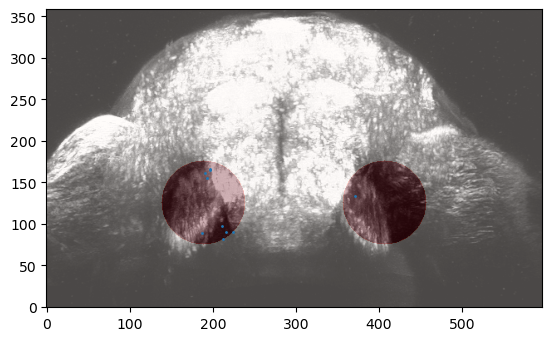

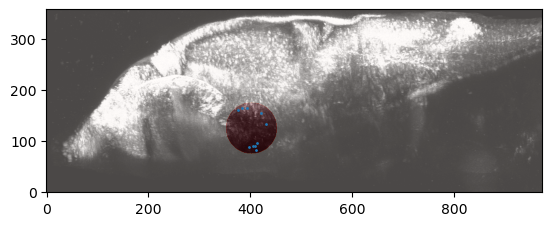

In [113]:
stack_img = atlas_ref
mask = target_mask
soma_locs = soma_xyz_all[whether_in_region,:]
fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=2)
ax.imshow(fig_bg, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=2)
ax.imshow(mask_img, cmap="Reds",origin="lower", alpha = 0.3)
ax.scatter(soma_locs[:,1], soma_locs[:,0], s= 1)

fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=1)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=1)
ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)
ax.scatter(soma_locs[:,0], soma_locs[:,2], s= 1)

fig, ax = plt.subplots(1,1)
fig_bg = np.max(stack_img, axis=0)
ax.imshow(fig_bg.T, cmap="gray",origin="lower")
mask_img = np.max(mask, axis=0)
ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)
ax.scatter(soma_locs[:,1], soma_locs[:,2], s= 1)

In [114]:
np.array(filelist)[whether_in_region]

array(['T_150324_fixed_1_3_full_tracing.swc', 'T_180112_16_2.swc',
       'T_160705_9_6.swc', 'T_150508_fixed_55m_6_1b_full_tracing.swc',
       'T_161019_1_3.swc', 'T_160708_HuCxBG_13_2.swc',
       'T_161121_HuCxBG_8_2.swc', 'T_161129_0_2.swc', 'T_151110_7_3.swc',
       'T_160704_1_2.swc'], dtype='<U48')

/tmp/ipykernel_3095375/4013632246.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


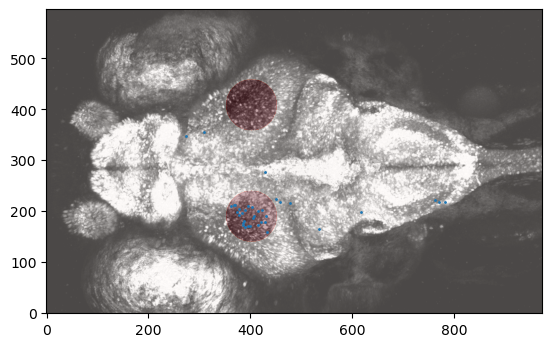

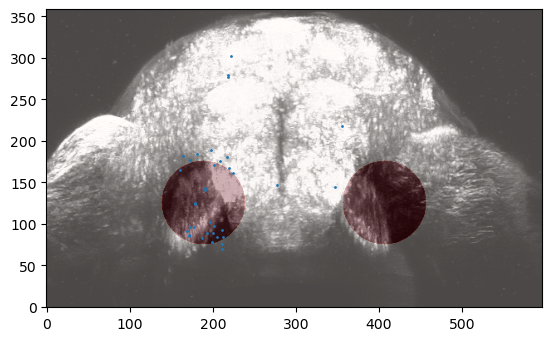

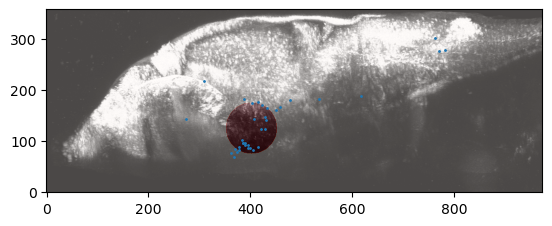

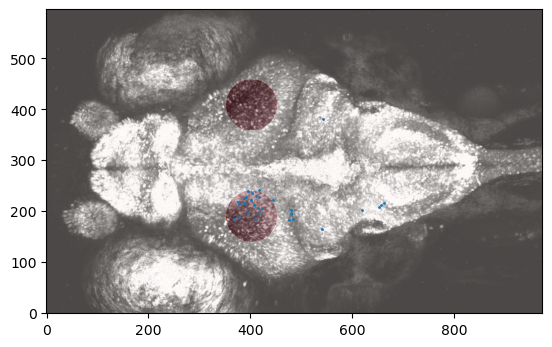

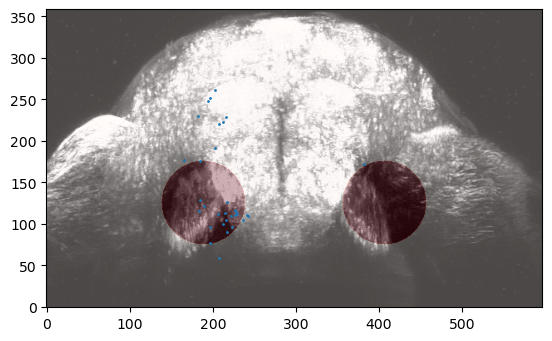

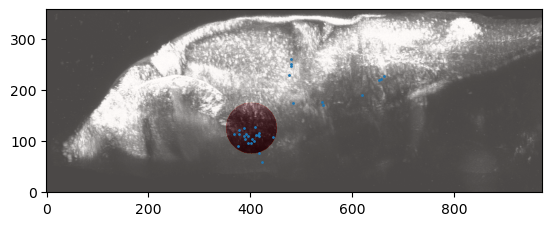

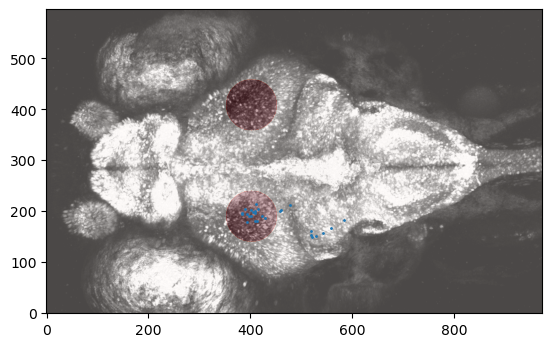

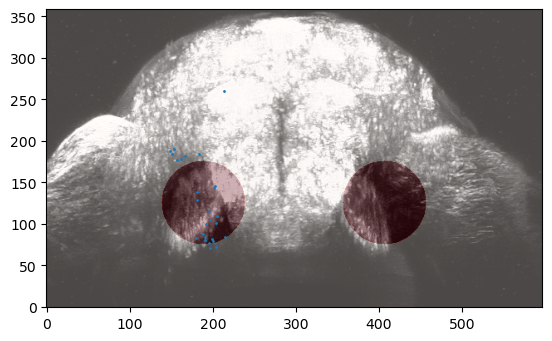

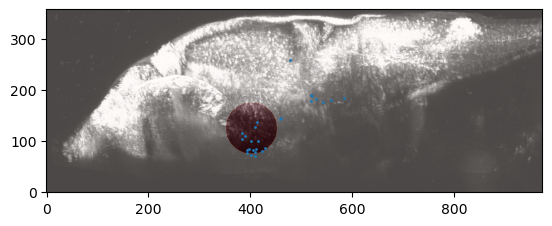

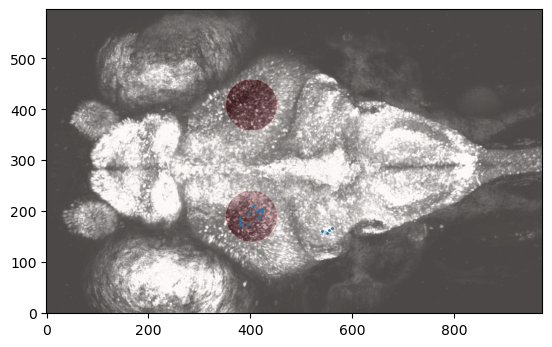

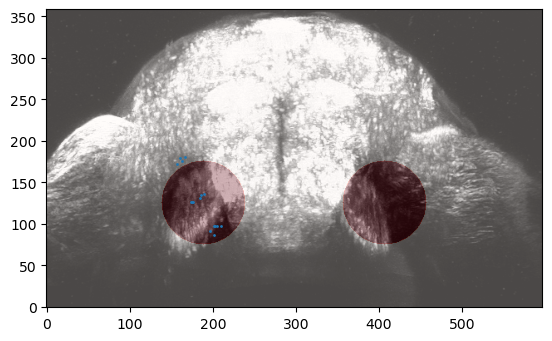

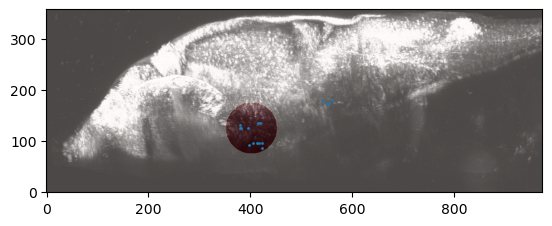

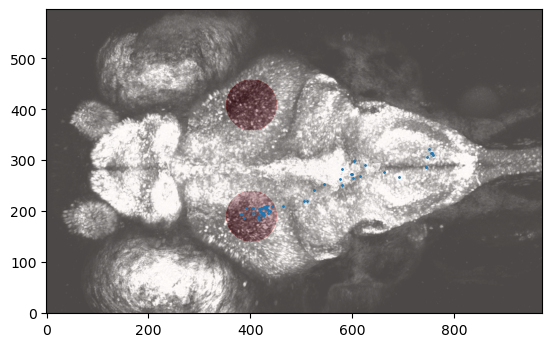

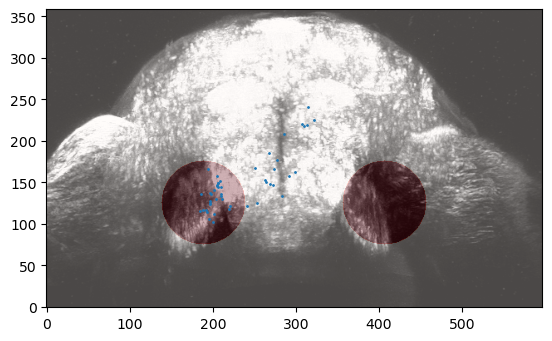

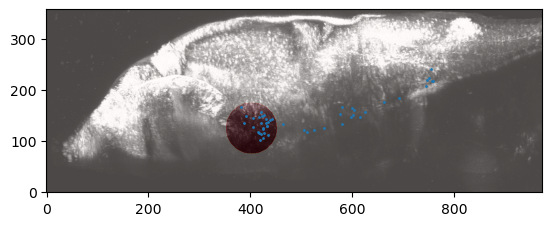

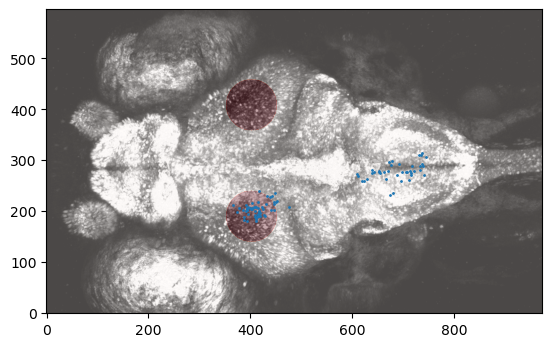

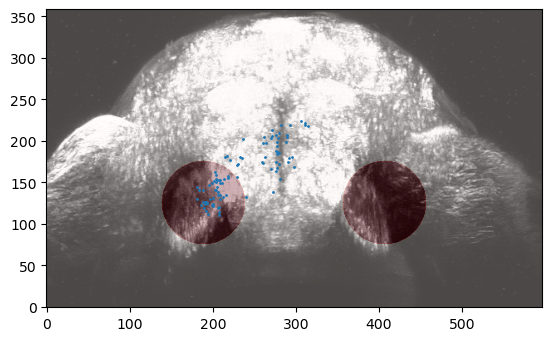

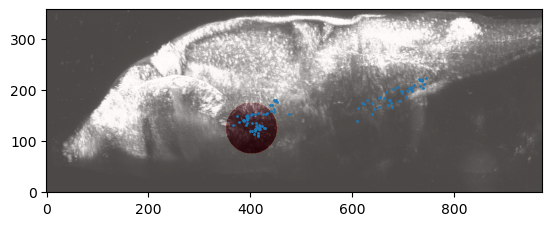

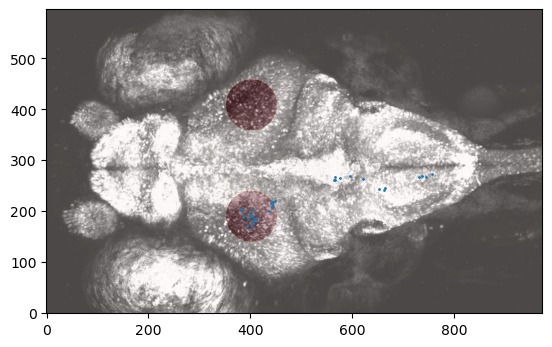

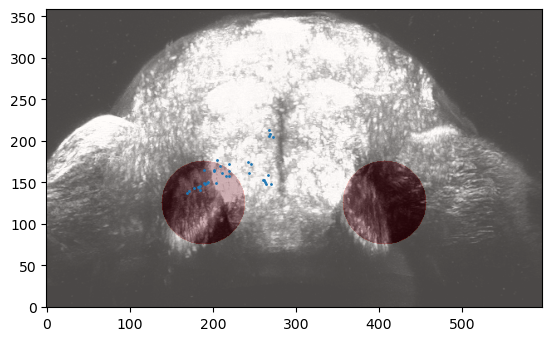

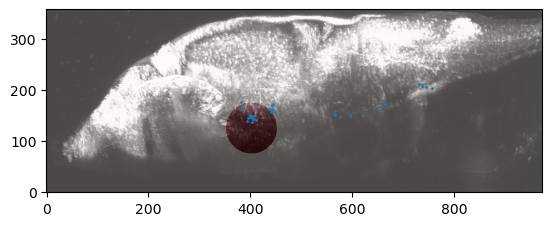

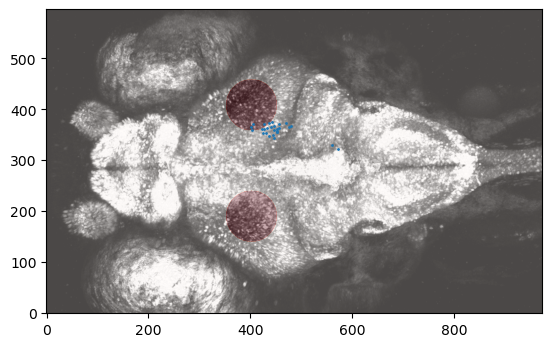

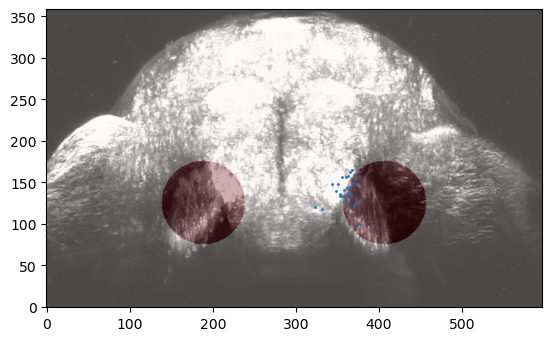

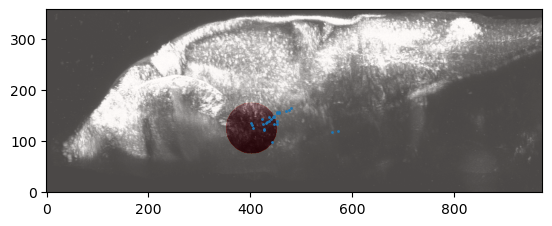

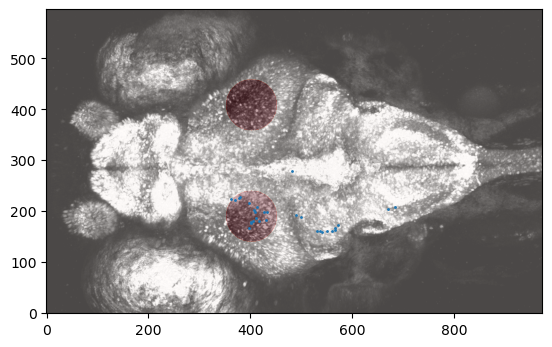

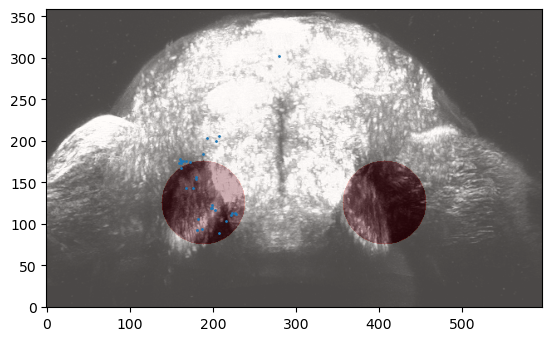

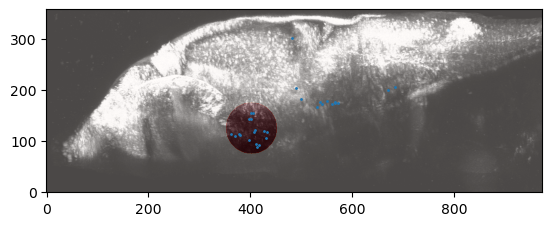

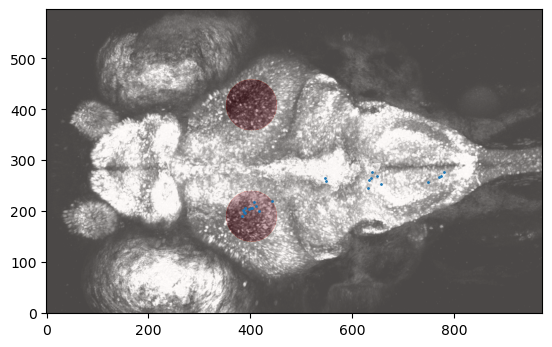

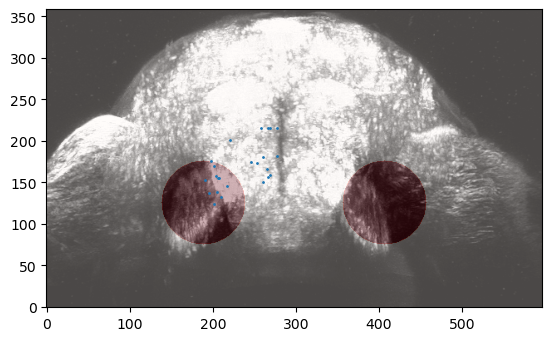

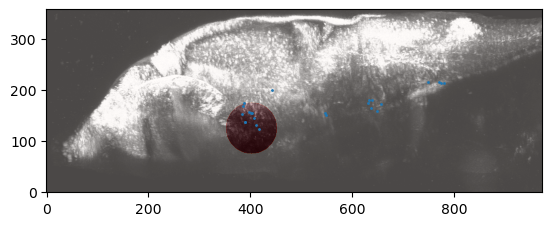

In [115]:
for i in range(np.sum(whether_in_region)):
    filename = np.array(filelist)[whether_in_region][i]
    swc_data = readSWC(os.path.join(datapath, filename))
    endpoints = findEndpoints(swc_data, return_node = True);
    endpoints_xyz = endpoints[:,[2,3,4]]
    
    stack_img = atlas_ref
    mask = target_mask
    soma_locs = endpoints_xyz
    fig, ax = plt.subplots(1,1)
    fig_bg = np.max(stack_img, axis=2)
    ax.imshow(fig_bg, cmap="gray",origin="lower")
    mask_img = np.max(mask, axis=2)
    ax.imshow(mask_img, cmap="Reds",origin="lower", alpha = 0.3)
    ax.scatter(soma_locs[:,1], soma_locs[:,0], s= 1)
    
    fig, ax = plt.subplots(1,1)
    fig_bg = np.max(stack_img, axis=1)
    ax.imshow(fig_bg.T, cmap="gray",origin="lower")
    mask_img = np.max(mask, axis=1)
    ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)
    ax.scatter(soma_locs[:,0], soma_locs[:,2], s= 1)
    
    fig, ax = plt.subplots(1,1)
    fig_bg = np.max(stack_img, axis=0)
    ax.imshow(fig_bg.T, cmap="gray",origin="lower")
    mask_img = np.max(mask, axis=0)
    ax.imshow(mask_img.T, cmap="Reds",origin="lower", alpha = 0.3)
    ax.scatter(soma_locs[:,1], soma_locs[:,2], s= 1)